### Problem Statement
Scaler is an online tech-versity offering intensive computer science & Data Science courses through live classes delivered by tech leaders and subject matter experts. The meticulously structured program enhances the skills of software professionals by offering a modern curriculum with exposure to the latest technologies. It is a product by InterviewBit.

You are working as a data scientist with the analytics vertical of Scaler, focused on profiling the best companies and job positions to work for from the Scaler database. You are provided with the information for a segment of learners and tasked to cluster them on the basis of their job profile, company, and other features. Ideally, these clusters should have similar characteristics.

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
import re, datetime

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,5

In [127]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE

In [128]:
df = pd.read_csv('scaler_clustering.csv')
print('Shape',df.shape)

Shape (205843, 7)


In [129]:
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [130]:
df.drop('Unnamed: 0', axis=1, inplace=True)

### Data Dictionary:

1. Email_hash- Anonymised Personal Identifiable Information (PII)
2. Company_hash- Current employer of the learner
3. orgyear- Employment start date
4. CTC- Current CTC
5. Job_position- Job profile in the company
6. CTC_updated_year: Year in which CTC got updated (Yearly increments, Promotions)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   email_hash        205843 non-null  object 
 2   orgyear           205757 non-null  float64
 3   ctc               205843 non-null  int64  
 4   job_position      153281 non-null  object 
 5   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


### <span style='color:green'>Drop Duplicates</span>

In [132]:
df.drop_duplicates(inplace=True)

In [133]:
df.shape

(205810, 6)

`Removed duplicatd rows`

### <span style='color:green'>Missing values treatment</span>

In [134]:
(df.isna().sum()/df.shape[0])*100

company_hash         0.021379
email_hash           0.000000
orgyear              0.041786
ctc                  0.000000
job_position        25.531801
ctc_updated_year     0.000000
dtype: float64

In [135]:
df.dropna(subset=['company_hash', 'orgyear', 'job_position'], axis=0, inplace=True)

In [136]:
df['orgyear'] = df['orgyear'].astype('int').astype('object')
df['ctc_updated_year']= df['ctc_updated_year'].astype('int').astype('object')

In [137]:
(df.isna().sum()/df.shape[0])*100

company_hash        0.0
email_hash          0.0
orgyear             0.0
ctc                 0.0
job_position        0.0
ctc_updated_year    0.0
dtype: float64

In [138]:
df.shape

(153188, 6)

`Removed all missing values rows as company_hash and org_years missing % are very less.`
`Job position is a categorical variable and also dependent on other categorical variables only so removed those missing values.`

### <span style='color:green'>Check unqiue values</span>

In [139]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_hash,153188,34203,nvnv wgzohrnvzwj otqcxwto,5308,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email_hash,153188,133146,3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orgyear,153188.0,70.0,2018.0,19001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctc,153188.0,NaN,NaN,NaN,2366614.100243,11877176.170482,2.0,570000.0,1000000.0,1720000.0,200000000.0
job_position,153188,1017,Backend Engineer,43532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctc_updated_year,153188.0,7.0,2019.0,56780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
df['orgyear'].unique()

array([2016, 2018, 2015, 2017, 2019, 2012, 2013, 2003, 2006, 2014, 2011,
       2020, 2021, 2008, 2022, 2009, 2005, 2010, 2004, 2007, 2002, 2023,
       2001, 1981, 2031, 2024, 1996, 2000, 1999, 1995, 1992, 1973, 1991,
       1998, 1990, 1997, 1988, 2025, 2029, 1993, 1982, 2026, 1985, 1994,
       1972, 1989, 0, 1987, 3, 91, 2027, 2, 1976, 4, 5, 1971, 1977, 1986,
       1984, 83, 1970, 1, 1979, 2028, 2204, 38, 1900, 201, 6, 200],
      dtype=object)

`In orgyear, some values are irrelavant, we need to remove these rows from dataset.`

In [141]:
df = df.loc[(df['orgyear'] > 1950) & (df['orgyear'] <  2022)]
df.reset_index(drop=True)
df.shape

(152314, 6)

In [142]:
df['ctc'].value_counts()

600000     5407
1000000    5142
400000     4814
800000     4671
500000     4505
           ... 
1759000       1
983999        1
2000999       1
13970         1
2276000       1
Name: ctc, Length: 3134, dtype: int64

In [143]:
df['ctc_updated_year'].unique()

array([2020, 2019, 2021, 2017, 2016, 2015, 2018], dtype=object)

In [144]:
df['job_position'].unique()

array(['Other', 'FullStack Engineer', 'Backend Engineer', ...,
       'Web / UI Designer', 'Azure data Factory',
       'Android Application developer'], dtype=object)

#### Clean job position

In [145]:
def get_clean_job(x):
    return re.sub('[^A-Za-z0-9 ]+', '', x)

In [146]:
df['job_position'] = df['job_position'].apply(get_clean_job)

In [147]:
print(f"Unique emails: {df['email_hash'].nunique()}, {(df['email_hash'].nunique()/df.shape[0])*100}")

Unique emails: 132367, 86.90402720695405


In [148]:
df['email_hash'].value_counts().sort_values(ascending=False)[:10]

6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c    9
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378    9
bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    8
c0eb129061675da412b0deb15871dd06ef0d7cd86eb5f7e8cc6a20b0d1938183    8
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee    8
b4d5afa09bec8689017d8b29701b80d664ca37b83cb883376b2e95191320da66    7
f5279f186abfb98a09d85a4467b99863c0bfc91c1147e542d6d23a6a69c9a7be    7
d15041f58bb01c8ee29f72e33b136e26bc32f3169a40b53d75fe7ae9cbb9a551    7
5dcd62ab1a606642f3dde6f536f5a343a8e943f215c463f945dd1bad9bff1531    7
caf66f38a8e742b7690dceb5b02d81ad8be684cfb6dd29b639a385b83748110b    7
Name: email_hash, dtype: int64

In [149]:
print(f"Unique companies: {df['company_hash'].nunique()}, {(df['company_hash'].nunique()/df.shape[0])*100}")

Unique companies: 34033, 22.34397363341518


In [150]:
df['company_hash'].value_counts().sort_values(ascending=False)[:10]

nvnv wgzohrnvzwj otqcxwto    5294
xzegojo                      3428
vbvkgz                       2564
wgszxkvzn                    2096
gqvwrt                       1954
zgn vuurxwvmrt vwwghzn       1923
vwwtznhqt                    1865
fxuqg rxbxnta                1720
bxwqgogen                    1672
wvustbxzx                    1347
Name: company_hash, dtype: int64

In [151]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_hash,152314,34033,nvnv wgzohrnvzwj otqcxwto,5294,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email_hash,152314,132367,6842660273f70e9aa239026ba33bfe82275d6ab0d20124...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orgyear,152314.0,47.0,2018.0,19001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctc,152314.0,NaN,NaN,NaN,2328391.321842,11638665.943861,2.0,570000.0,1000000.0,1720000.0,200000000.0
job_position,152314,1003,Backend Engineer,43407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctc_updated_year,152314.0,7.0,2019.0,56717.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. In CTC, some outliers are there as mean and 50% percentile have big difference.
2. 34k unique comapnies in dataset.
3. nvnv wgzohrnvzwj otqcxwto is top most company with 5.3k records.
4. One email id is repeating 9 times in dataset - 3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94...
5. Year 2018 is on top for org_year.
6. backend engineer is on top with 43k records.
7. 2019 is on top for ctc_updated year

#### <span style='color:blue'>...</span>

In [152]:
# df_encoded = df.copy()

In [153]:
# for col in df_encoded.select_dtypes(include=['object']).columns:
#     le = LabelEncoder()
#     df_encoded[col] = le.fit_transform(df_encoded[col])

In [154]:
# le = LabelEncoder()
# le = le.fit(df['job_position'])
# le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
# type(le_name_mapping)

In [155]:
# df_encoded.head()

In [156]:
# knn_imp = KNNImputer(n_neighbors=5).set_output(transform="pandas")
# imp_arr = knn_imp.fit_transform(df_encoded)

In [157]:
# new_jobs = []
# for i in np.array(imp_arr['job_position'], dtype=int):
#     new_jobs.append(le_name_mapping[i])
# len(new_jobs)

In [158]:
# df[df['job_position'].isna()].head()

### <span style='color:green'>Feature Engineering</span>

`We can find total years of exp with ctc_updated_year-orgyear`

In [159]:
current_year = datetime.datetime.now().year
df['years_of_exp'] = current_year - df['orgyear'].astype(int)
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_exp
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,7
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,5
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015,2000000,Backend Engineer,2020,8
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017,700000,Backend Engineer,2019,6
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017,1400000,FullStack Engineer,2019,6


In [160]:
df['years_of_exp'].value_counts()[:5]

5    19001
6    17922
7    17835
8    16179
4    13867
Name: years_of_exp, dtype: int64

`4-8 years of exp is most common in dataset.`

### <span style='color:green'>Manual Clustering</span>

#### Manual Clustering on the basis of learner’s company, job position and years of experience

In [161]:
def percentile(x):
    return x.quantile(0.75)

In [162]:
df_gp_3 = df.groupby(['company_hash', 'job_position', 'years_of_exp'])
df_gp_3 = df_gp_3.agg(comp_job_exp_mean = ('ctc', 'mean'), comp_job_exp_median = ('ctc', 'median'), comp_job_exp_75  = ('ctc', percentile), 
                      comp_job_exp_max = ('ctc', 'max'), comp_job_exp_min = ('ctc', 'min'), comp_job_exp_count = ('ctc', 'count'))
df_gp_3.reset_index(inplace=True)

In [163]:
df_gp_3.sample(5)

,company_hash,job_position,years_of_exp,comp_job_exp_mean,comp_job_exp_median,comp_job_exp_75,comp_job_exp_max,comp_job_exp_min,comp_job_exp_count
59477,uqvnyvb ogenfvqt,Backend Engineer,7,1025000.0,1025000.0,1037500.0,1050000,1000000,2
25146,lhzxutq ztnfgqpo,Other,13,2460000.0,2460000.0,2690000.0,2920000,2000000,2
75835,wvustbxzx,QA Engineer,15,1416500.0,1416500.0,1708250.0,2000000,833000,2
33966,nwk wgzohrnxzs rru,Product Designer,8,2200000.0,2200000.0,2200000.0,2200000,2200000,1
6984,bvhqxnxho ntrtwgb,Backend Engineer,13,800000.0,800000.0,800000.0,800000,800000,1


### Company & Job Position level

In [164]:
df_gp_2 = df.groupby(['company_hash', 'job_position'])
df_gp_2 = df_gp_2.agg(comp_job_mean = ('ctc', 'mean'), comp_job_median = ('ctc', 'median'), comp_job_75  = ('ctc', percentile), 
                      comp_job_max = ('ctc', 'max'), comp_job_min = ('ctc', 'min'), comp_job_count = ('ctc', 'count'))
df_gp_2.reset_index(inplace=True)

In [165]:
df_gp_2.sample(5)

,company_hash,job_position,comp_job_mean,comp_job_median,comp_job_75,comp_job_max,comp_job_min,comp_job_count
4065,btaxvztn,Frontend Engineer,1.592778e+06,1420000.0,1950000.0,3660000,600000,9
37391,tvstqwqgf,QA Engineer,1.600000e+06,1600000.0,1600000.0,1600000,1600000,1
38725,uqgwrghafvqt otqcxwto ucn rna,Cofounder,6.000000e+05,600000.0,600000.0,600000,600000,1
48450,wrtqxoj ogrhnxgzo ucn rna,FullStack Engineer,6.000000e+05,600000.0,600000.0,600000,600000,1
19989,ntdnqgz,FullStack Engineer,1.000000e+06,1000000.0,1000000.0,1000000,1000000,1


#### Company level

In [166]:
df_gp_1 = df.groupby(['company_hash'])
df_gp_1 = df_gp_1.agg(comp_mean = ('ctc', 'mean'), comp_median = ('ctc', 'median'), comp_75  = ('ctc', percentile), 
                      comp_max = ('ctc', 'max'),comp_min = ('ctc', 'min'), comp_count = ('ctc', 'count'))
df_gp_1.reset_index(inplace=True)

In [167]:
df_gp_1.sample(5)

,company_hash,comp_mean,comp_median,comp_75,comp_max,comp_min,comp_count
5302,ergfvmrt,2.650000e+06,2650000.0,2650000.0,2650000,2650000,1
2331,bowqxuno ojontb,8.600000e+05,860000.0,860000.0,860000,860000,1
23099,urvzxn ntonxzs,4.750000e+05,475000.0,487500.0,500000,450000,2
31537,xztav ojontbo ucn rna,2.800000e+06,2800000.0,2800000.0,2800000,2800000,1
16428,oyvf vwvatbj fgqrao rvqston rxct gzrxzt tahwvngq,1.620555e+06,1700000.0,1800000.0,2500000,585000,9


#### Merge all 3 DFs with original dataframe

In [168]:
df = df.merge(df_gp_3, how='left', left_on=['company_hash', 'job_position', 'years_of_exp'], 
         right_on=['company_hash', 'job_position', 'years_of_exp'])

df = df.merge(df_gp_2, how='left', left_on=['company_hash', 'job_position'], 
         right_on=['company_hash', 'job_position'])

df = df.merge(df_gp_1, how='left', left_on=['company_hash'], 
         right_on=['company_hash'])

In [169]:
df.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_exp,comp_job_exp_mean,comp_job_exp_median,comp_job_exp_75,comp_job_exp_max,comp_job_exp_min,comp_job_exp_count,comp_job_mean,comp_job_median,comp_job_75,comp_job_max,comp_job_min,comp_job_count,comp_mean,comp_median,comp_75,comp_max,comp_min,comp_count
68559,fxuqg rxbxnta,2645167ec4d824ca7694ac0fe0c5175727ee02938cf59f...,2014,400000,Backend Engineer,2021,9,1.061495e+07,620000.0,1000000.0,200000000,9000,20,2.324487e+06,600000.0,804999.75,200000000,4000,416,2.425564e+06,540000.0,800000.0,200000000,4000,1720
19466,erxupvqn,7ef8724b93ec034fad621cdc2376ee8786017d57d7d86c...,2014,2550000,Backend Engineer,2020,9,2.938239e+06,2895000.0,3677250.0,5550000,200000,46,2.897259e+06,2700000.0,3500000.00,8000000,10000,473,3.263018e+06,2600000.0,3520000.0,200000000,10000,753
47761,stzuvwn,342d66dba9a277e1732e2cb6477bcf99dba1c14d42ee22...,2014,1350000,Frontend Engineer,2021,9,1.107500e+06,1105000.0,1387500.0,1500000,720000,4,1.292222e+06,860000.0,1312500.00,8300000,220000,18,3.012180e+06,750000.0,1350000.0,200000000,2000,244
82210,ovbohzs qa xzonxnhnt xzaxv mvzsvrgqt,629a964c90637e4c2fa9ce611c2cc3df4c6d4c53995e53...,2017,1600000,Other,2015,6,2.220588e+06,2030000.0,2500000.0,5240000,770000,17,2.036818e+06,1939999.0,2487500.00,5240000,770000,55,1.949492e+06,1800000.0,2250000.0,9950000,15200,651
67252,e1 xzeg ogrhnxgz,cc1e2fc7bea6fabe0c61ef1f7f80c2e4b4ac7cea5668fa...,2017,200000,QA Engineer,2021,6,2.000000e+05,200000.0,200000.0,200000,200000,1,2.000000e+05,200000.0,200000.00,200000,200000,1,2.000000e+05,200000.0,200000.0,200000,200000,1


In [170]:
# df_gp_3[(df_gp_3['company_hash'] == 'qtrxvzwt xzegwgbb rxbxnta') & (df_gp_3['job_position']=='FullStack Engineer') & (df_gp_3['years_of_exp']==5)]

#### Create flag with comparison of Avg

In [171]:
def get_flag(val, median, percentile75):
    if val > percentile75:
        return 1
    elif (val > median) & (val <= percentile75):
        return 2
    else:
        return 3

In [172]:
df['designation'] = df.apply(lambda x : get_flag(x['ctc'], x['comp_job_exp_median'], x['comp_job_exp_75']), axis=1)
df['Class'] = df.apply(lambda x : get_flag(x['ctc'], x['comp_job_median'], x['comp_job_75']), axis=1)
df['Tier'] = df.apply(lambda x : get_flag(x['ctc'], x['comp_median'], x['comp_75']), axis=1)

In [173]:
df.sample(5)

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_exp,comp_job_exp_mean,comp_job_exp_median,comp_job_exp_75,comp_job_exp_max,comp_job_exp_min,comp_job_exp_count,comp_job_mean,comp_job_median,comp_job_75,comp_job_max,comp_job_min,comp_job_count,comp_mean,comp_median,comp_75,comp_max,comp_min,comp_count,designation,Class,Tier
60544,ygztjftrr ntwyzgrgsj ogrhnxgzo,2dbddf6fa747fcf40c305673b9501fd62144e5c6da1ec6...,2011,600000,Frontend Engineer,2020,12,6.000000e+05,600000.0,600000.0,600000,600000,1,1.160857e+06,800000.0,1613000.0,2300000,400000,7,1.549250e+06,1400000.0,2025000.0,5500000,400000,80,3,3,3
53391,vlxgwgb,d474d55ab56b23484509249a9d87c679ec40a5acc41326...,2012,4300000,Backend Engineer,2021,11,4.300000e+06,4300000.0,4300000.0,4300000,4300000,1,2.003636e+06,1500000.0,2365000.0,4350000,360000,11,1.903913e+06,1500000.0,2425000.0,4350000,360000,23,3,1,1
104353,toutq,4eae384959a48ea548eaf67c271625c7e0fbc0d3ac989b...,2017,1800000,Devops Engineer,2020,6,1.800000e+06,1800000.0,1800000.0,1800000,1800000,1,1.800000e+06,1800000.0,1800000.0,1800000,1800000,1,1.525000e+06,1550000.0,1925000.0,2300000,700000,4,3,3,2
33013,gqvwrt,c0d709bf068c7313bcce0765e420233e410b8d95905fc4...,2000,3800000,FullStack Engineer,2019,23,2.800000e+06,2800000.0,3300000.0,3800000,1800000,2,1.493511e+06,1300000.0,1900000.0,6500000,8000,400,1.700978e+06,1300000.0,2000000.0,70000000,7500,1954,1,1,1
105967,xzntr wgqugqvnxgz,ba7a99207f143bc8a9a980f3a4eae82c77045cbe1a1911...,2011,2200000,Backend Engineer,2019,12,1.608889e+06,1700000.0,2000000.0,2300000,140000,9,2.327875e+06,1370000.0,2000000.0,50000000,70000,96,2.723604e+06,1435000.0,2500000.0,100000000,2000,278,1,1,2


In [174]:
df['designation'].value_counts()

3    118158
1     23076
2     11080
Name: designation, dtype: int64

In [175]:
df['Class'].value_counts()

3    102964
1     29176
2     20174
Name: Class, dtype: int64

In [176]:
df['Tier'].value_counts()

3    93601
1    31980
2    26733
Name: Tier, dtype: int64

1. Most of the users have designation, Class and Tier 3 only.
2. Where Desgination, class and Tier 2 is on last wrt counts.

#### <span style='color:blue'>Top 10 employees (earning more than most of the employees in the company) - Tier 1</span> 

In [177]:
# b = df[df['Tier']==1].groupby('company_hash').agg({'email_hash':lambda x : list(x), 'ctc':lambda x : list(x)}).explode(['email_hash', 'ctc'])
# b.reset_index(inplace=True)
# b[b['company_hash']=='zxztrtvuo']

In [178]:
top10_tier1 =  df[df['Tier']==1].groupby('company_hash')
top10_tier1 = top10_tier1.apply(lambda x: x.sort_values(["ctc"], ascending = False)[:10])
top10_tier1.reset_index(drop=True, inplace=True)

In [179]:
top10_tier1[top10_tier1['company_hash']=='zxztrtvuo'][['company_hash', 'email_hash','job_position', 'ctc', 'Tier', 'Class']]

,company_hash,email_hash,job_position,ctc,Tier,Class
16575,zxztrtvuo,303aab779b6daea19317b430f600b0e8543f4c66ca3251...,Backend Engineer,11950000,1,1
16576,zxztrtvuo,8c7b6b29eddd85e147c7d02507735f2c250d6c40d34bb2...,Backend Architect,3000000,1,3
16577,zxztrtvuo,da254908334157ddde0078c9bf967114ae67cc00816f4c...,Devops Engineer,2700000,1,3
16578,zxztrtvuo,66a9ddfbd95e2f5fb57e5f649bd22eeeb7c1a9aec920b8...,Frontend Engineer,2500000,1,1
16579,zxztrtvuo,4ebf56aec16de134303f4c54752d26bc12791e8b20b28b...,Frontend Engineer,2500000,1,1
16580,zxztrtvuo,12b42968b62afcbac9252406392275719b35c99d39aefb...,Frontend Engineer,2500000,1,1
16581,zxztrtvuo,1cd0a52ed52dae24d605d9cdc8536499c10ce62bfb070f...,Data Scientist,2250000,1,1
16582,zxztrtvuo,3385dc93ba44f4f1cc237ef4f8e057dab2f693d8961b64...,Frontend Engineer,1800000,1,1
16583,zxztrtvuo,16c227291d7c4f151b52599cc15e1ddd6f7e12a694753c...,Backend Engineer,1780000,1,1
16584,zxztrtvuo,3879b9a1e356ed20363fffd6871207eb908b38c864a2db...,FullStack Engineer,1500000,1,1


#### <span style='color:blue'>Bottom 10 employees (earning less than most of the employees in the company)- Tier 3</span> 

In [180]:
bottom10_tier1 =  df[df['Tier']==1].groupby('company_hash')
bottom10_tier1 = bottom10_tier1.apply(lambda x: x.sort_values(["ctc"], ascending = True)[:10])
bottom10_tier1.reset_index(drop=True, inplace=True)

In [181]:
bottom10_tier1[bottom10_tier1['company_hash'] =='zxztrtvuo'][['company_hash', 'email_hash','job_position', 'ctc', 'Tier', 'Class']]

,company_hash,email_hash,job_position,ctc,Tier,Class
16575,zxztrtvuo,748ebd12e4b5415465dea44130d057d8336b8753fa410f...,Backend Engineer,1360000,1,1
16576,zxztrtvuo,3027ca561b65f99da2f65bf3d85c6bb5d5687c67e69e89...,Data Scientist,1370000,1,3
16577,zxztrtvuo,10d566c5fca40ffe1d133b79594d071880711ef480da9f...,Data Scientist,1400000,1,2
16578,zxztrtvuo,748ebd12e4b5415465dea44130d057d8336b8753fa410f...,Backend Engineer,1440000,1,1
16579,zxztrtvuo,3879b9a1e356ed20363fffd6871207eb908b38c864a2db...,FullStack Engineer,1500000,1,1
16580,zxztrtvuo,16c227291d7c4f151b52599cc15e1ddd6f7e12a694753c...,Backend Engineer,1780000,1,1
16581,zxztrtvuo,3385dc93ba44f4f1cc237ef4f8e057dab2f693d8961b64...,Frontend Engineer,1800000,1,1
16582,zxztrtvuo,1cd0a52ed52dae24d605d9cdc8536499c10ce62bfb070f...,Data Scientist,2250000,1,1
16583,zxztrtvuo,66a9ddfbd95e2f5fb57e5f649bd22eeeb7c1a9aec920b8...,Frontend Engineer,2500000,1,1
16584,zxztrtvuo,4ebf56aec16de134303f4c54752d26bc12791e8b20b28b...,Frontend Engineer,2500000,1,1


#### <span style='color:blue'>Top 10 employees of data science in Amazon / TCS etc earning more than their peers - Class 1</span> 

In [182]:
top10_class1_DS =  df[(df['Class']==1) & (df['job_position'] == 'Data Scientist')].groupby('company_hash')
top10_class1_DS = top10_class1_DS.apply(lambda x: x.sort_values(["ctc"], ascending = False)[:10])
top10_class1_DS.reset_index(drop=True, inplace=True)

In [183]:
top10_class1_DS[top10_class1_DS['company_hash']=='zxtrotz'][['company_hash', 'email_hash','job_position', 'ctc', 'Tier', 'Class']]

,company_hash,email_hash,job_position,ctc,Tier,Class
925,zxtrotz,751b1fb94f9054ecc14b44ebf91c3cbd92a47ea0194492...,Data Scientist,3000000,1,1
926,zxtrotz,10a1836569e6ad820e170f6d899d2992efd5d0efc0e35c...,Data Scientist,2200000,1,1
927,zxtrotz,2b7979bb62110fbb5e97f3f7f25d79f102536d3b84d538...,Data Scientist,1090000,2,1


#### <span style='color:blue'>Bottom 10 employees of data science in Amazon / TCS etc earning less than their peers - Class 3</span> 


In [184]:
bottom10_class1_DS =  df[(df['Class']==3) & (df['job_position'] == 'Data Scientist')].groupby('company_hash')
bottom10_class1_DS = bottom10_class1_DS.apply(lambda x: x.sort_values(["ctc"], ascending = True)[:10])
bottom10_class1_DS.reset_index(drop=True, inplace=True)

In [185]:
bottom10_class1_DS[bottom10_class1_DS['company_hash'] == 'adw ntwyzgrgsj'][['company_hash', 'email_hash','job_position', 'ctc', 'Tier', 'Class']]

,company_hash,email_hash,job_position,ctc,Tier,Class
23,adw ntwyzgrgsj,c4420d1b47d52e5237b85b0f65e62ed8645b1b032d01c9...,Data Scientist,680000,2,3
24,adw ntwyzgrgsj,6ca1d030df1927f2c0904548a99dea059fd0aeaf39cb21...,Data Scientist,700000,2,3
25,adw ntwyzgrgsj,1443f6d836c4dc24a7a79f7f81702e6b684abdd22ea50e...,Data Scientist,800000,2,3
26,adw ntwyzgrgsj,f77930e695dabbd49c7e2dc1d9cfe96c1d3b4808418c65...,Data Scientist,850000,2,3
27,adw ntwyzgrgsj,9d8dcc11f1524e2b9837295c74aa304420812e4044b2d5...,Data Scientist,880000,2,3
28,adw ntwyzgrgsj,e345ebb6d86762b48880f27b4527f46e18c376b675f617...,Data Scientist,1070000,2,3


#### <span style='color:blue'>Top 10 employees in Amazon- X department - having 5/6/7 years of experience earning more than their peers - Tier X</span> 

In [186]:
top10_tierX_exp5 =  df[df['years_of_exp'].isin([5,6,7])].groupby(['company_hash', 'job_position'])
top10_tierX_exp5 = top10_tierX_exp5.apply(lambda x: x.sort_values(["ctc"], ascending = False)[:10])
top10_tierX_exp5.reset_index(drop=True, inplace=True)

In [187]:
top10_tierX_exp5[top10_tierX_exp5['company_hash']=='1bs'][['company_hash', 'years_of_exp',
                                                              'email_hash','job_position', 'ctc', 'Tier', 'Class', 'designation']]

,company_hash,years_of_exp,email_hash,job_position,ctc,Tier,Class,designation
10,1bs,5,158e0bba9db45a85e623c23b5c66d16e5daadcc8d0e4b4...,Android Engineer,900000,3,1,3
11,1bs,6,d0d06e9bb510f55e1e26e25cc8e1f6dfbe31384d3864a5...,Android Engineer,700000,3,3,3
12,1bs,7,31db7b806a82aac024462d4c97e70eed918bf8c3193b7c...,Backend Engineer,3750000,1,1,1
13,1bs,7,9c02076a74a2b8a64a6e003fa0a2e4115fc717dacb3585...,Backend Engineer,2320000,1,1,3
14,1bs,6,8eae91898e936449907a20b9eca37a398eb8d5f185f77c...,Backend Engineer,1610000,1,2,1
15,1bs,6,13f9b6b7b59baa88d975991323dabdd66424550d633a88...,Backend Engineer,1400000,2,2,1
16,1bs,6,08168bb1394cb9ebd0934c0021eba942cf915450259baf...,Backend Engineer,1300000,3,3,2
17,1bs,6,45266e6b42ccbf0a0945d2a88692907a96a5346994ca6c...,Backend Engineer,1200000,3,3,3
18,1bs,5,6b01808bba4c2d50258b068274232251620630cb252a9c...,Backend Engineer,1100000,3,3,1
19,1bs,6,13f9b6b7b59baa88d975991323dabdd66424550d633a88...,Backend Engineer,1000000,3,3,3


#### <span style='color:blue'>Top 10 companies (based on their CTC)</span> 

In [188]:
top_10_comp = df[['company_hash', 'comp_median']].drop_duplicates().sort_values(by='comp_median', ascending=False)[:10]
top_10_comp

,company_hash,comp_median
8606,yvfrtq uvwptq,200000000.0
2144,sgraygbk wgzohrnxzs,200000000.0
46937,wo ogen ogrhnxgzo,200000000.0
30487,gqmxn ogenfvqt xzw,200000000.0
4247,xzaxv ugftq wgqugqvnxgz rna,200000000.0
40911,qvaxwvr bxzao ntwyzgrgsj ucn rna,200000000.0
25531,uqgxzntz ntwyzgrgsj,200000000.0
10192,bjnqvy tztqsj xzaxv ucn rna,200000000.0
18957,yxzahlv sgmvr ogrhnxgzo,200000000.0
18228,apvnxv,200000000.0


#### <span style='color:blue'>Top 2 positions in every company (based on their CTC)</span> 

In [189]:
top_10_comp_job = df[['company_hash', 'job_position', 
                      'comp_job_median']].drop_duplicates().sort_values(by='comp_job_median', ascending=False)
top_10_comp_job1 = top_10_comp_job.groupby(['company_hash']).head(2).reset_index(drop=True)
# top_10_comp_job1[top_10_comp_job1['company_hash']=='qmo']
top_10_comp_job1.loc[10:20]



,company_hash,job_position,comp_job_median
10,vao ogrhnxgz,Other,200000000.0
11,qvj mhoxztoo ntwyzgrgsxto ucn rna,Frontend Engineer,200000000.0
12,gqmxn ogenfvqt xzw,Backend Engineer,200000000.0
13,axctqoxexta tztqsj ogrhnxgzo ucn rna,Other,200000000.0
14,ctwngq oyvato,Backend Architect,200000000.0
15,wgbutntzn ojontbo xzw,Other,200000000.0
16,axowgctq agrrvq,Other,200000000.0
17,anaw tduqtoo rxbxnta,Other,200000000.0
18,nvnv ntrtotqcxwto rna,Other,200000000.0
19,pvnvqxv mhxrntwp ucn rna,Other,200000000.0


### <span style='color:green'>Data processing for Unsupervised clustering - Label encoding/ One- hot encoding, Standardization of data</span> 


In [190]:
df.head()

,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_exp,comp_job_exp_mean,comp_job_exp_median,comp_job_exp_75,comp_job_exp_max,comp_job_exp_min,comp_job_exp_count,comp_job_mean,comp_job_median,comp_job_75,comp_job_max,comp_job_min,comp_job_count,comp_mean,comp_median,comp_75,comp_max,comp_min,comp_count,designation,Class,Tier
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016,1100000,Other,2020,7,1.100000e+06,1100000.0,1100000.0,1100000,1100000,1,1.085000e+06,1085000.0,1092500.0,1100000,1070000,2,1.115667e+06,1070000.0,1500000.0,1771000,500000,9,3,1,2
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018,449999,FullStack Engineer,2019,5,7.742856e+05,750000.0,900000.0,1200000,449999,7,9.511363e+05,800000.0,1300000.0,2000000,300000,22,2.496042e+06,900000.0,1685000.0,200000000,10000,325,3,3,3
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015,2000000,Backend Engineer,2020,8,2.000000e+06,2000000.0,2000000.0,2000000,2000000,1,2.000000e+06,2000000.0,2000000.0,2000000,2000000,1,2.000000e+06,2000000.0,2000000.0,2000000,2000000,1,3,3,3
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017,700000,Backend Engineer,2019,6,1.158571e+06,1200000.0,1405000.0,1750000,700000,7,1.500000e+06,1540000.0,1800000.0,3500000,520000,25,1.570273e+06,1350000.0,1900000.0,4700000,200000,55,3,3,3
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017,1400000,FullStack Engineer,2019,6,1.400000e+06,1400000.0,1400000.0,1400000,1400000,1,8.466667e+05,600000.0,1000000.0,1400000,540000,3,9.880000e+05,1000000.0,1400000.0,1400000,540000,5,3,1,2


In [191]:
df_cluster = df[['company_hash', 'email_hash', 'ctc', 'job_position', 'years_of_exp', 'designation', 'Class', 'Tier']]
df_cluster.head()

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier
0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,1100000,Other,7,3,1,2
1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,449999,FullStack Engineer,5,3,3,3
2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2000000,Backend Engineer,8,3,3,3
3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,700000,Backend Engineer,6,3,3,3
4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,1400000,FullStack Engineer,6,3,1,2


#### <span style='color:blue'>Label encoding</span> 

In [192]:
df_cluster.nunique()

company_hash     34033
email_hash      132367
ctc               3134
job_position      1003
years_of_exp        47
designation          3
Class                3
Tier                 3
dtype: int64

`As no of unqiue values in each variable is very high, we should go for Label encoding`

In [193]:
for col in df_cluster.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_cluster[col] = le.fit_transform(df_cluster[col])

In [194]:
df_cluster.head()

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier
0,868,56884,1100000,453,7,3,1,2
1,18016,91413,449999,288,5,3,3,3
2,14169,37473,2000000,138,8,3,3,3
3,11023,124116,700000,138,6,3,3,3
4,18477,57937,1400000,288,6,3,1,2


#### <span style='color:blue'>Data Standardization</span> 

In [195]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(df_cluster)
X_jobs = scaler.transform(df_cluster)

In [196]:
X_jobs.head()

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier
0,-1.646002,-0.243256,-0.105544,0.796252,-0.299254,0.512487,-1.865994,-0.497679
1,0.036821,0.660521,-0.161393,-0.063397,-0.769527,0.512487,0.648066,0.732477
2,-0.340705,-0.751328,-0.028216,-0.844897,-0.064117,0.512487,0.648066,0.732477
3,-0.649438,1.516504,-0.139913,-0.844897,-0.534390,0.512487,0.648066,0.732477
4,0.082061,-0.215694,-0.079768,-0.063397,-0.534390,0.512487,-1.865994,-0.497679


### <span style='color:green'>Unsupervised Learning</span> 

#### <span style='color:blue'>Cluster Tendency</span> 

In [197]:
from pyclustertend import hopkins

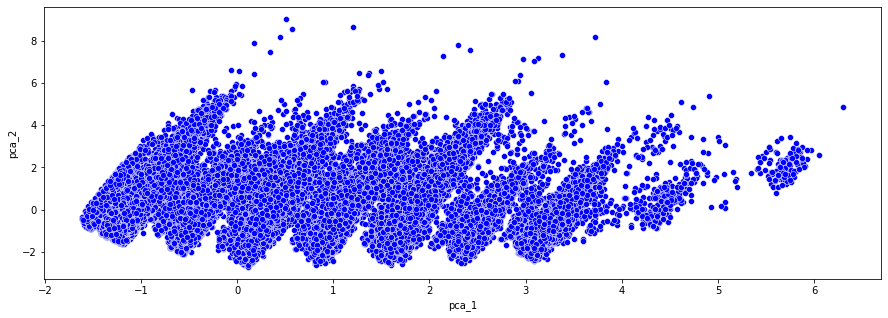

In [198]:
from sklearn.decomposition import PCA

#perform PCA
pca = PCA(n_components=2) #2 components = 2 Dimensions
principalComponents = pca.fit_transform(X_jobs)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca_1', 'pca_2'])
sns.scatterplot(x=principalDf['pca_1'], y=principalDf['pca_2'], color='blue')
plt.show()


`Clearly we can see no of clusters 6-8 with the help of PCA.`

In [199]:
l = [] 
for i in range(20):
    H=hopkins(X_jobs, sampling_size=1000)
    l.append(H)
print('Hopkins Statistics score: ', np.mean(l))
    

Hopkins Statistics score:  0.04729289214204156


`Score is tends to 0, it means that the data is not uniformly distributed. Hence clustering can be useful to classify the observations.`

#### <span style='color:blue'>Elbow Method</span> 

In [200]:
# Inertia = Within Cluster Sum of Squares
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_jobs)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

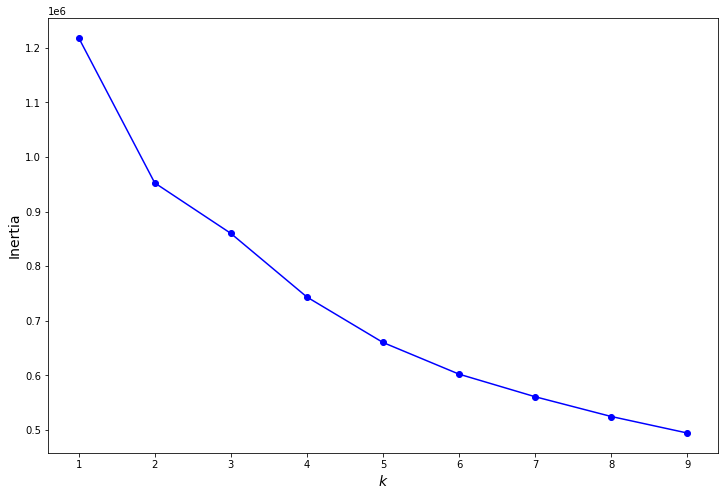

In [201]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

`From elbow method optimal k value can be 4, 5, 6. lets check with other methods.`

### <span style='color:green'>K- means clustering</span> 

In [202]:
k = 6
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_jobs)

#### <span style='color:blue'>Visulize clusters</span> 

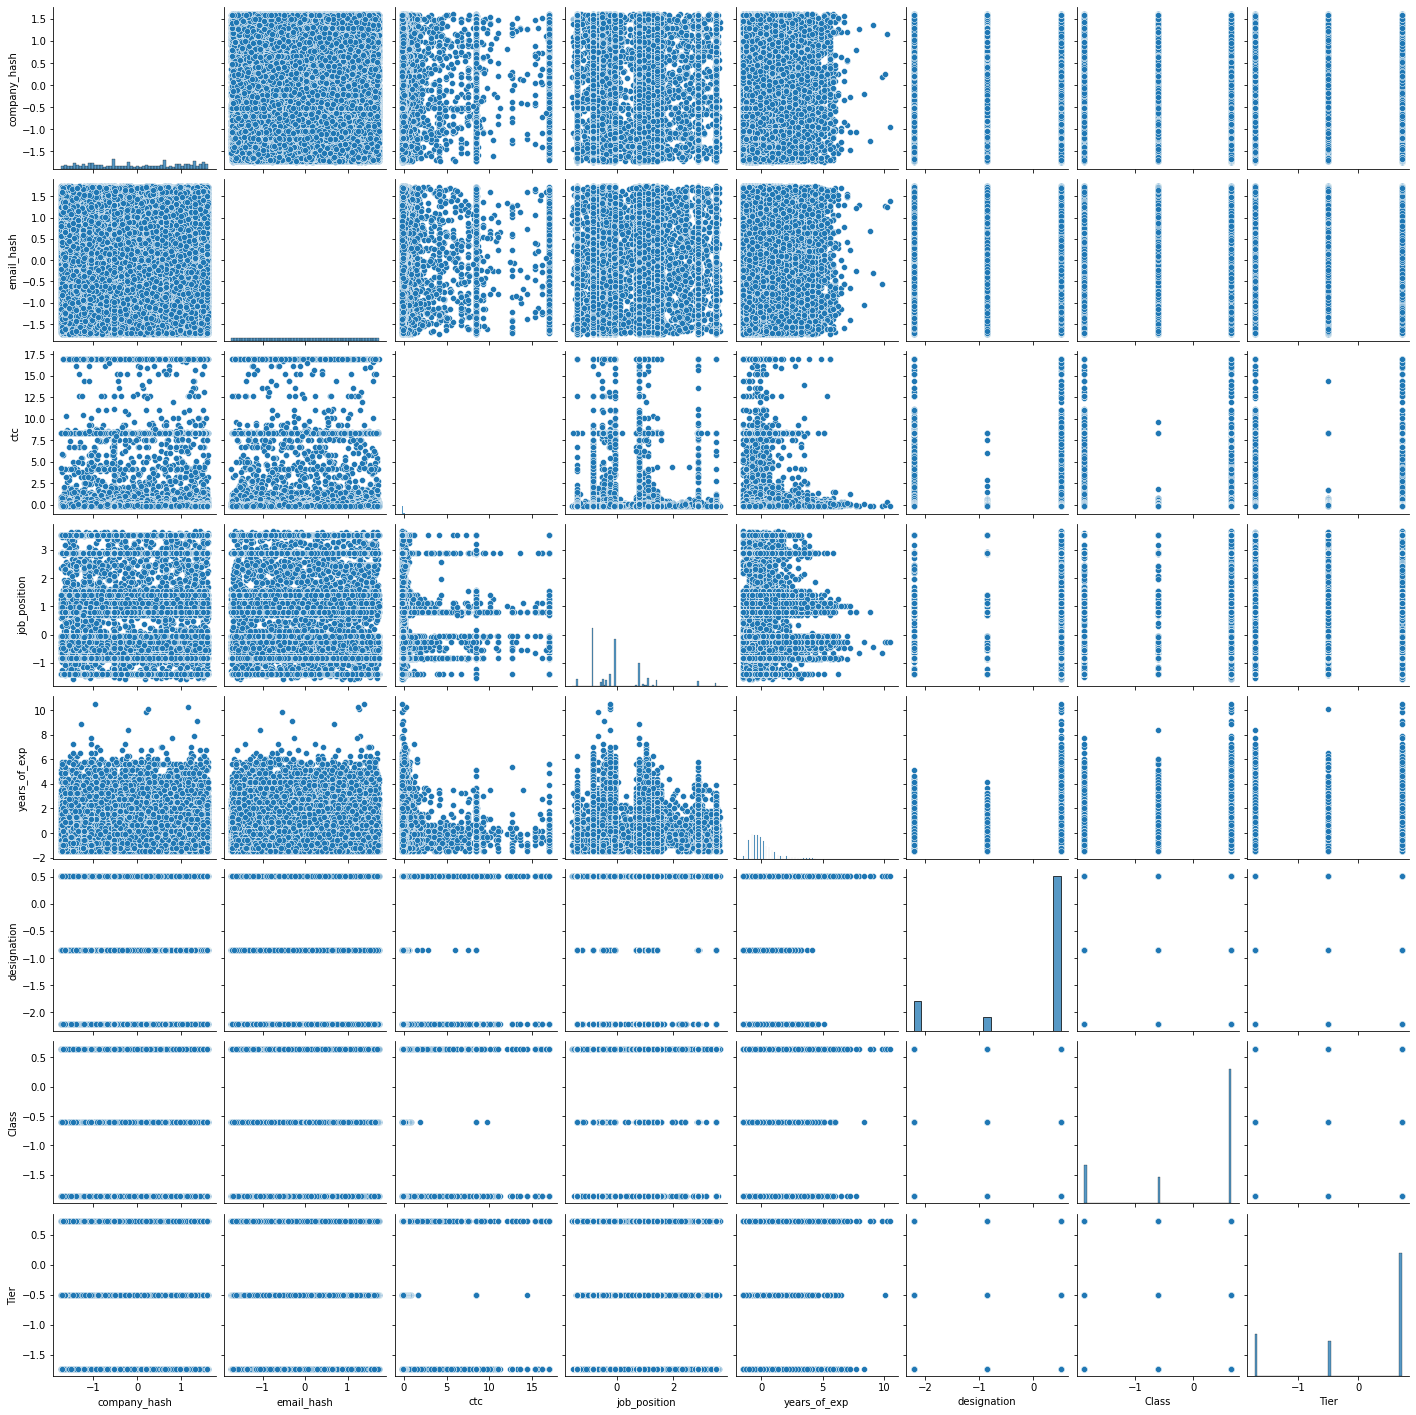

In [203]:
sns.pairplot(X_jobs)
plt.show()

In [204]:
km_clusters = pd.DataFrame(df_cluster, columns=df_cluster.columns)
km_clusters['label'] = kmeans.labels_
km_clusters.head()

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
0,868,56884,1100000,453,7,3,1,2,0
1,18016,91413,449999,288,5,3,3,3,3
2,14169,37473,2000000,138,8,3,3,3,2
3,11023,124116,700000,138,6,3,3,3,2
4,18477,57937,1400000,288,6,3,1,2,0


In [205]:
##coordinates of the cluster centers
list(kmeans.cluster_centers_)

[array([-0.02617817,  0.00363541,  0.01245266, -0.1864738 ,  1.14456938,
         0.46205663, -0.81670846, -1.24637517]),
 array([-0.0104494 ,  0.01751717, -0.11197968,  1.74158663,  0.08339405,
         0.3977826 ,  0.44018236,  0.48533257]),
 array([-0.91318309, -0.00445994, -0.109435  , -0.35122362, -0.27677387,
         0.40268835,  0.56301498,  0.5853341 ]),
 array([ 0.93668378, -0.01024363, -0.11857632, -0.31555482, -0.29942988,
         0.38323823,  0.5517651 ,  0.5781204 ]),
 array([ 0.03349021,  0.00471196, -0.00667599, -0.17962245, -0.18516736,
        -1.91223541, -1.31630927, -1.03944714]),
 array([ 4.39024953e-02,  2.51832145e-02,  1.12084662e+01,  3.63985748e-01,
        -1.06874106e-02, -5.21461302e-01, -7.41930930e-01, -9.51908971e-01])]

Text(0, 0.5, 'ctc')

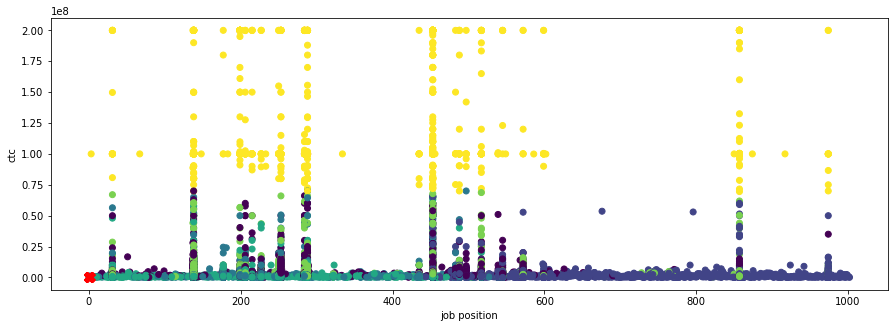

In [206]:
plt.scatter(km_clusters['job_position'], km_clusters['ctc'], c=km_clusters['label'])
plt.scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 2], 
            color="red",
            marker="X",
            s=100)
plt.xlabel('job position')
plt.ylabel('ctc')

Text(0, 0.5, 'ctc')

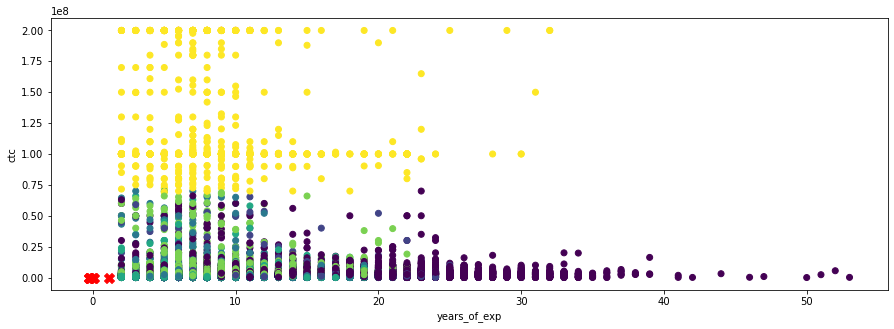

In [207]:
plt.scatter(km_clusters['years_of_exp'], km_clusters['ctc'], c=km_clusters['label'])
plt.scatter(kmeans.cluster_centers_[:, 4], kmeans.cluster_centers_[:, 2], 
            color="red",
            marker="X",
            s=100)
plt.xlabel('years_of_exp')
plt.ylabel('ctc')

In [208]:
sample_data = km_clusters.sample(n=10000)
X = sample_data.drop('label', axis=1)
y = sample_data['label']
z2 = TSNE(n_components=2, random_state=0, perplexity=30).fit_transform(X)

In [209]:
z2.shape

(10000, 2)

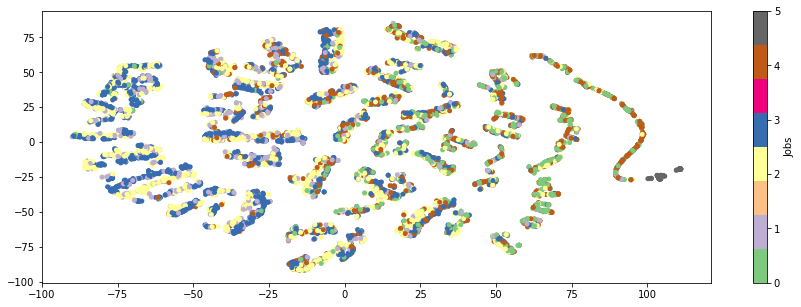

In [210]:
fig, ax = plt.subplots()
im = ax.scatter(z2[:,0], z2[:,1], s=25, c=y, cmap='Accent', edgecolor='none')
cbar = fig.colorbar(im, ax=ax,label='Jobs')

1. Plots with two variable have shown good clusters with k=6.
2. with t-SNE also, we can see some pattern but not clearly giving signal for k=6

In [211]:
df['label'] = kmeans.labels_
df2 = df[['company_hash', 'email_hash', 'ctc', 'job_position', 'years_of_exp', 'designation', 'Class', 'Tier', 'label']]

In [212]:
df2[df2['label']==0].sample(5)

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
146202,pqgzgo ogrhnxgzo,53854ee28b667d315e1bf278c2c01460302163bf318c96...,1600000,Devops Engineer,8,3,1,2,0
10869,zgn vuurxwvmrt vwwghzn,a8378c5b49723d1011f88dc7984f6317de776e3fe6d1f1...,1200000,Backend Engineer,13,3,2,1,0
84700,wqtaxn ohxoot,4df486e196adfa0a51e9cf5dba4e74e8ad93b80c6dd89d...,3600000,Engineering Leadership,21,3,1,1,0
76303,crgwxnj wrgha vuurxwvnxgzo,d1961d26723abe2e9b13c0bc7c9ec385352a69c5451e46...,2000000,Backend Engineer,9,3,1,1,0
52853,wxtzv wgqugqvnxgz,43a0a46067d4c4fc095331b9b586764490b78ae64ad650...,2900000,Engineering Leadership,17,3,2,1,0


In [213]:
df2[df2['label']==1].sample(5)

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
81975,nwo xgz,e737650037c1f8dfc5d215534db53a2c8707dd4e8b05a9...,1300000,System Engineer,6,3,1,1,1
142734,btqtaxny,8d6b1d897ae8b2bc203307c1b54680d4cfbd4dcd749e63...,600000,SDET,9,3,3,3,1
29859,ntvbrtvot otqcxwto,f3605c972b5a62aae5d41ee7e98434d8e3b61c78448bd8...,400000,Non Coder,9,3,3,2,1
94960,vagmt,862421c6d125e04b12898c87286e1b54f550b495566cd9...,1250000,Other,10,3,3,3,1
147421,cxov,4eff6dfe800456d06520f8d16ba2a3e7f1fb1235dacac0...,1420000,SDET,7,3,3,3,1


In [214]:
df2[df2['label']==2].sample(5)

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
83081,ovmqt wgqugqvnxgz,43c283ce6cab3ab98347e1cd59c3b183286a8d505bd80f...,1400000,Backend Engineer,5,3,3,3,2
64436,fxuqg rxbxnta,91b9f21cd9135ab10b9f17d7cbe16334125e6288238927...,350000,Other,5,3,3,3,2
67979,oxej ntwyzgrgsxto,b4a17a24ab4963370468c90f22fac24a11809397b5bbda...,900000,Devops Engineer,9,3,3,2,2
104059,ovbohzs qa xzonxnhnt xzaxv mvzsvrgqt,5fe5436f0a76988bddb10fe28ae3fafe3efb72a1d09665...,1400000,Backend Engineer,7,3,3,3,2
73765,ctvnxct,819b5e0f8a38957d9f6ded2b2ae51ef9e1e67ea6eb1ce0...,700000,FullStack Engineer,14,3,3,3,2


In [215]:
df2[df2['label']==3].sample(5)

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
71294,xmb,1b92631172ad690baec4f0c5d66bd06ac4587c9823c00e...,400000,Devops Engineer,9,3,3,3,3
54542,wgszxkvzn,89cefd6ce9f0be29785093bba08b6ce5f1a7bce446b5df...,425000,Other,9,3,3,3,3
94253,srgmvrrgsxw,c38038346ea24ddbfdc763f55e9812ba72ed3d0ff1e4e3...,480000,Engineering Intern,3,3,3,3,3
147103,xzeg tast xzaxv rna,e99deeb75cb264871f990c2c431e7bc8538a6ce726cf5d...,1500000,Engineering Leadership,8,3,3,2,3
72340,wvoyh,6351b69458fbc89dfe36f205f913fe7af9abaea12637ea...,800000,Frontend Engineer,8,3,3,3,3


In [216]:
df2[df2['label']==4].sample(5)

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
27112,srgmvrrgsxw,8bc08ebfce008a75e9c769929b4cb6681e29d471d36085...,1050000,Other,10,1,2,2,4
42828,nvnv wgzohrnvzwj otqcxwto,2918c0ec9ba21e7c4faee6d1d632363ea95410100a0d3e...,500000,FullStack Engineer,4,2,2,2,4
98051,xzegqbvnxwv,352ba996f95d711d9fafbf1076b8abb101cb7666c3d485...,2500000,Backend Engineer,9,2,1,2,4
133739,qxmmgz wgbbhzxwvnxgzo,224f09408e4cb782387f6d2c33cb2aae2791f150792c02...,654000,Backend Engineer,4,1,3,3,4
117497,wvustbxzx,ba67c0d0da1e85e401ef1cbc31251760b86bcfdb95fc66...,1370000,Backend Engineer,9,1,1,1,4


In [217]:
df2[df2['label']==5].sample(5)

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
48269,vwwtznhqt,bf6c34589ebfa4e2ffbd61e65fb2e9a5264bace7b60019...,99900000,Backend Engineer,5,1,1,1,5
14253,erxupvqn,ef9987c98edad9756ad357f551c5c861f46f8e493b358c...,200000000,Other,7,1,1,1,5
25398,wrghaotp,a1223067ab5c4ff7fcf39ed4c053057f06090a57fc05ba...,127600000,Data Scientist,6,3,3,1,5
8487,ovbvoynx,b903f41eb416898bc24e574ae13ac3118c5a025516b21e...,100250000,Other,7,3,3,3,5
15244,avxzxp myvopvq,6c9f75ce2616e7ddfbca733249059a3456940921295a2f...,100520000,Other,9,3,1,1,5


### <span style='color:green'>Hierarchical Clustering</span> 

In [218]:
sample_X = X_jobs.sample(2000)
H_clusters = sch.linkage(sample_X, method='ward') 

`Lets take sample of 2000 as it will give  memory issue with full data`

Text(0, 0.5, 'distance')

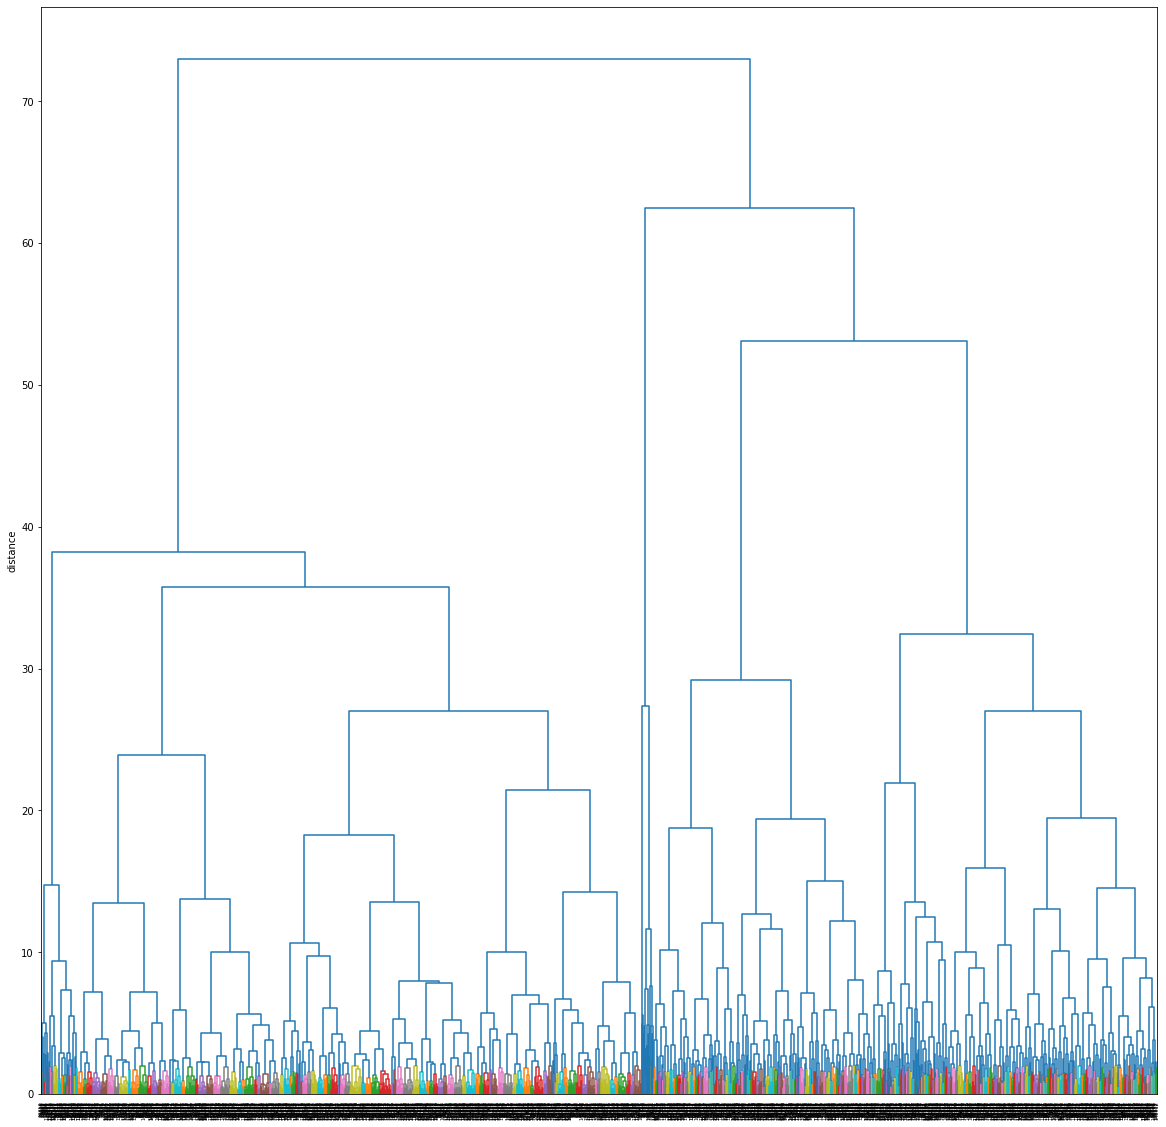

In [219]:
fig, ax = plt.subplots(figsize=(20, 20))
sch.dendrogram(H_clusters, labels=sample_X.index, ax=ax, color_threshold=2)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

`From above plot, 6 clusters look fine as max distance is there.`

In [220]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=6, affinity = 'euclidean', linkage = 'ward')
y_pred = hc.fit_predict(sample_X)

In [221]:
h_clusters = pd.DataFrame(sample_X, columns=sample_X.columns)
h_clusters['label'] = y_pred
h_clusters.head(3)

,company_hash,email_hash,ctc,job_position,years_of_exp,designation,Class,Tier,label
40230,1.122295,-0.916488,-0.165689,2.901091,-1.004664,0.512487,0.648066,0.732477,4
117617,-1.093108,-0.589805,-0.145068,3.510661,0.171020,0.512487,0.648066,0.732477,4
75227,-0.432560,-0.304897,-0.165689,-1.402367,-0.299254,0.512487,0.648066,0.732477,3


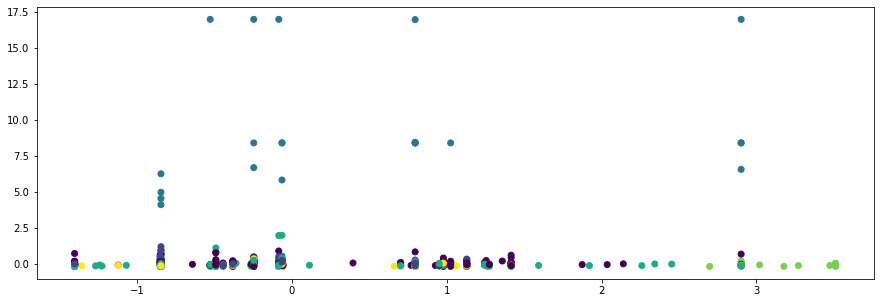

In [222]:
plt.scatter(h_clusters['job_position'], h_clusters['ctc'], c=h_clusters['label'])
plt.show()

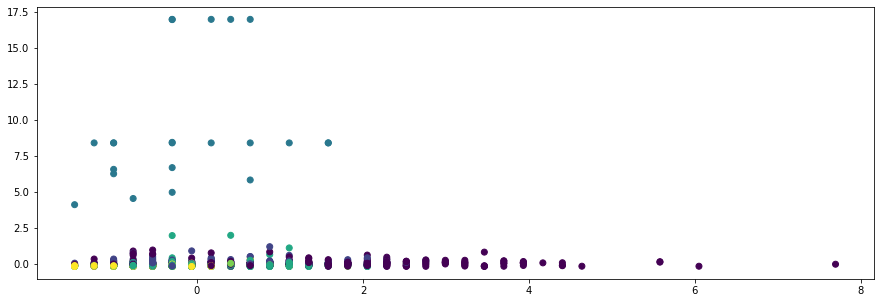

In [223]:
plt.scatter(h_clusters['years_of_exp'], h_clusters['ctc'], c=h_clusters['label'])
plt.show()

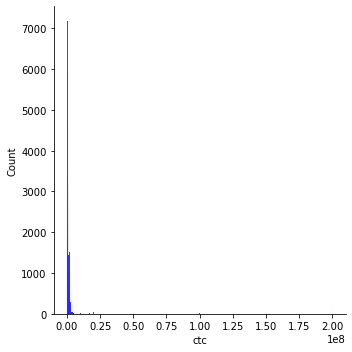

In [224]:
sns.displot(df['ctc'], color='blue')
plt.show()

### <span style='color:Red'>Insights</span> 

1. Most of the users are into Designation 3, Class 3 and Tier 3 companies.
2. Most of the users have job position as bankend engineer only.
3. CTC median and mean is not near to each other as it shows a large right tailed distribution.
4. Most of the users have total experience between 4-8 years only.
5. We have noticed 6 clustes from elbow method, t-SNE and confirmed with kmeans output.
6. Hierarchial clustering is also showing 6 clusters as optinal number with max distance.
7. Samples look fine into all clusters.

### <span style='color:Red'>Recommendation</span> 

1. As of most of the users are from desgination 3, class 2 and tier 3, there is chance to upskill them and move into category 1.
2. We can show median salary range to new users and attract them with results.
3. Users are from 4-8 experience so this is better category to upskill and give them better placement opportunities.
4. We can figure our emerging profiles and provide courses around those.